In [1]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
DATA_DIR = "face-mask-detection"
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    obj = root.find('object')
    class_name = obj.find('name').text
    box = obj.find('bndbox')
    xmin = int(box.find('xmin').text)
    ymin = int(box.find('ymin').text)
    xmax = int(box.find('xmax').text)
    ymax = int(box.find('ymax').text)
    return xmin, ymin, xmax, ymax, class_name

images, bboxes, labels = [], [], []

for file in os.listdir(os.path.join(DATA_DIR, "annotations")):
    if file.endswith(".xml"):
        xml_path = os.path.join(DATA_DIR, "annotations", file)
        img_path = os.path.join(DATA_DIR, "images", file.replace(".xml", ".png"))
        if not os.path.exists(img_path):
            img_path = os.path.join(DATA_DIR, "images", file.replace(".xml", ".jpg"))
        if not os.path.exists(img_path):
            continue
        xmin, ymin, xmax, ymax, class_name = parse_annotation(xml_path)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        bbox_norm = [xmin/w, ymin/h, xmax/w, ymax/h]
        label_onehot = np.zeros(3)
        label_onehot[classes.index(class_name)] = 1
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        images.append(img_resized)
        bboxes.append(bbox_norm)
        labels.append(label_onehot)

images = np.array(images, dtype=np.float32)
bboxes = np.array(bboxes, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)

X_train, X_val, bbox_train, bbox_val, label_train, label_val = train_test_split(
    images, bboxes, labels, test_size=0.2, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, {'bbox': bbox_train, 'class': label_train}))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, {'bbox': bbox_val, 'class': label_val}))

def augment(img, target):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.random_contrast(img, 0.7, 1.3)
    img = tf.image.random_saturation(img, 0.7, 1.3)
    img = tf.image.random_hue(img, 0.1)
    return img, target

train_ds = train_ds.shuffle(1000).map(augment).batch(32).prefetch(2)
val_ds = val_ds.batch(32)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, weights='imagenet')

for layer in base_model.layers[-20:]:
    layer.trainable = True

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name='bbox')(x)
class_output = tf.keras.layers.Dense(3, activation='softmax', name='class')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=[bbox_output, class_output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={'bbox': tf.keras.losses.MeanSquaredError(),
          'class': tf.keras.losses.CategoricalCrossentropy()},
    loss_weights={'bbox': 5.0, 'class': 1.0},
    metrics={'class': tf.keras.metrics.CategoricalAccuracy()}
)

model.summary()
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

model.save('face_mask_detector1.h5')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,430,663 (9.27 MB)

 Trainable params: 2,396,551 (9.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 168s 7s/step - bbox_loss: 0.0845 - class_categorical_accuracy: 0.3644 - class_loss: 1.2941 - loss: 1.7178 - val_bbox_loss: 0.0707 - val_class_categorical_accuracy: 0.9064 - val_class_loss: 0.4862 - val_loss: 0.8299
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - bbox_loss: 0.0511 - class_categorical_accuracy: 0.8420 - class_loss: 0.5144 - loss: 0.7697 - val_bbox_loss: 0.0497 - val_class_categorical_accuracy: 0.9064 - val_class_loss: 0.3371 - val_loss: 0.5868
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 150s 7s/step - bbox_loss: 0.0394 - class_categorical_accuracy: 0.8473 - class_loss: 0.4222 - loss: 0.6192 - val_bbox_loss: 0.0470 - val_class_categorical_accuracy: 0.9006 - val_class_loss: 0.3086 - val_loss: 0.5437
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - bbox_loss: 0.0386 - class_categorical_accuracy: 0.8986 - class_loss: 0.2965 - loss: 0.4892 - val_bbox_loss: 0.0437 - val_class_categorical_accuracy: 0.9006 - val_class_loss: 0.2807 - val_l

In [8]:
model.save('face_mask_detector.h5')

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Bounding Box MSE: 0.0363
Classification Accuracy: 0.8772


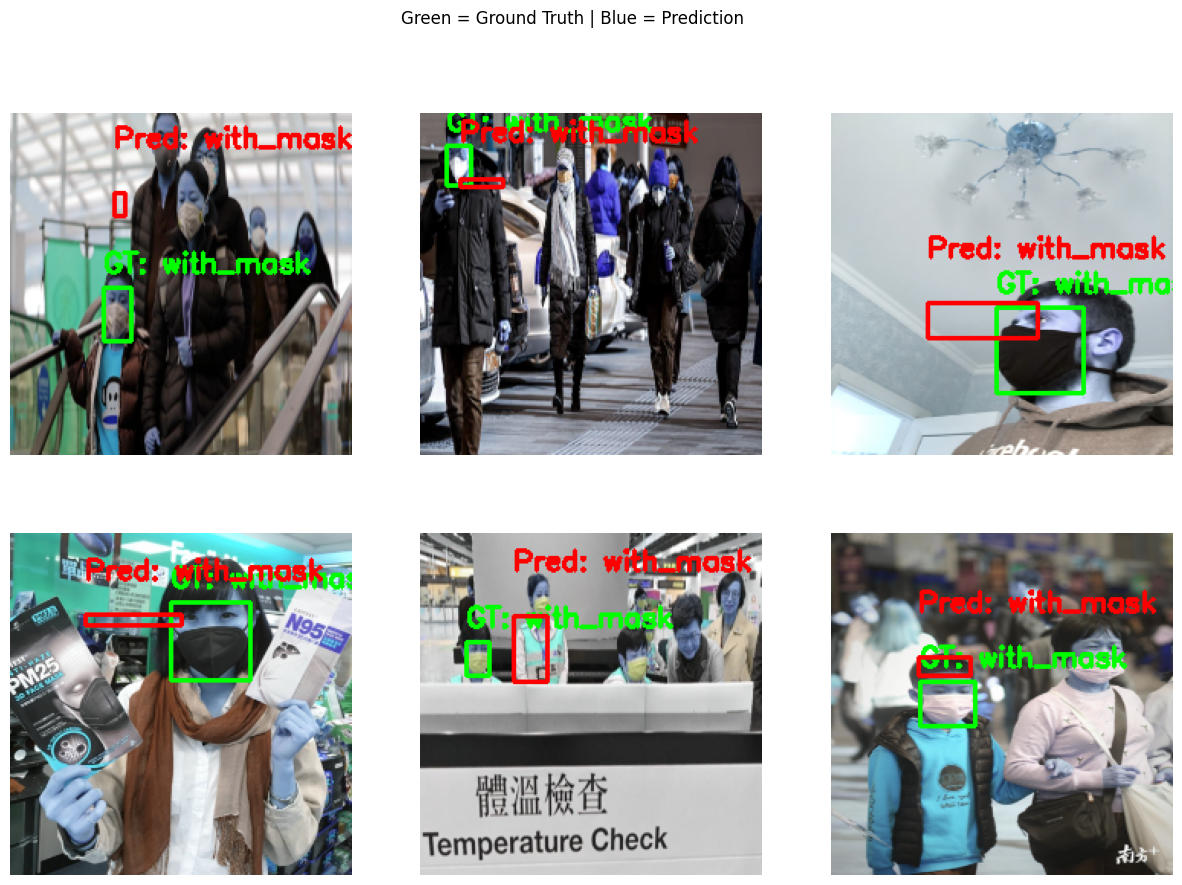

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf

model = tf.keras.models.load_model('face_mask_detector.h5')

pred_bbox, pred_class = model.predict(X_val)

bbox_mse = np.mean(np.square(pred_bbox - bbox_val))
class_acc = np.mean(np.argmax(pred_class, axis=1) == np.argmax(label_val, axis=1))

print(f"Bounding Box MSE: {bbox_mse:.4f}")
print(f"Classification Accuracy: {class_acc:.4f}")

classes = ["with_mask","without_mask","mask_weared_incorrect"]
plt.figure(figsize=(15,10))
for i in range(6):
    idx = random.randint(0, len(X_val)-1)
    img = (X_val[idx]*255).astype(np.uint8)
    h, w = img.shape[:2]

    gt = (bbox_val[idx] * [w,h,w,h]).astype(int)
    gt_class = classes[np.argmax(label_val[idx])]

    pb = (pred_bbox[idx] * [w,h,w,h]).astype(int)
    pred_class_name = classes[np.argmax(pred_class[idx])]

    img = cv2.rectangle(img, (gt[0],gt[1]), (gt[2],gt[3]), (0,255,0), 2)
    img = cv2.putText(img, f"GT: {gt_class}", (gt[0], gt[1]-10),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    img = cv2.rectangle(img, (pb[0],pb[1]), (pb[2],pb[3]), (255,0,0), 2)
    img = cv2.putText(img, f"Pred: {pred_class_name}", (pb[0], pb[1]-30),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Green = Ground Truth | Blue = Prediction")
plt.show()
